In [6]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from config import *
from functions import *
from sim_new import *
from read_ramses import *
import const


In [89]:
sim = Sim(9, "bturbfunc", "data_d47_l1_b5.npz")


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.


### quick look

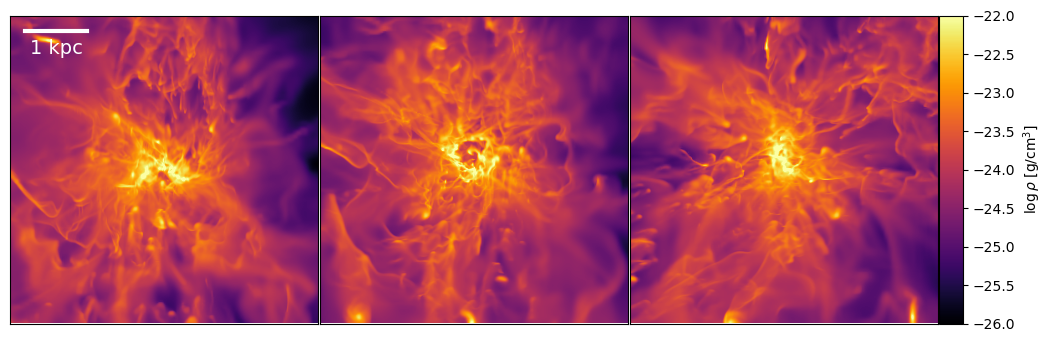

In [123]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(3):
    img = sim.proj_axis('density', idx_axis=i)
    im = sim.plot_img(img, ax=axs[i], do_log=True, cmap='inferno', vmin=1e-26, vmax=1e-22)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
sim.add_dis_to_ax(axs[0], 1*const.kpc)
add_cbar_to_fig(im, fig, label=r'$\log \rho$ [${\rm g/cm^3}$]')


[]

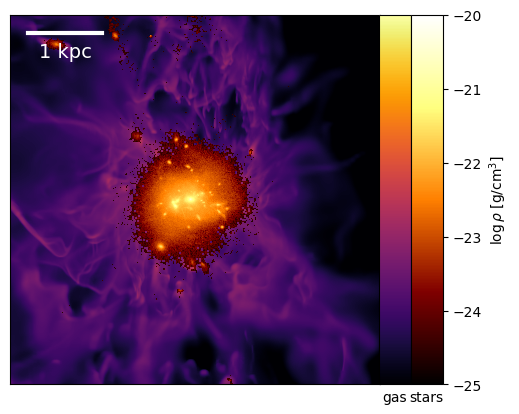

In [39]:
idx_axis = X

fig, ax = plt.figure(), plt.gca()

img = sim.proj_axis('density', idx_axis=idx_axis)
im1 = sim.plot_img(img, ax=ax, do_log=True, cmap='inferno', vmin=1e-25, vmax=1e-20)

img = sim.proj_axis('density_star', idx_axis=idx_axis)
im2 = sim.plot_img(img, ax=ax, do_log=True, cmap='afmhot', vmin=1e-25, vmax=1e-20)
    
sim.add_dis_to_ax(ax, 1*const.kpc)
cbar = add_cbar_to_fig(im1, fig, bbox=[.8, .11, .05, .77])
cbar.ax.set_xlabel(r'gas')
cbar.ax.set_yticks([])
cbar = add_cbar_to_fig(im2, fig, bbox=[.85, .11, .05, .77], label=r'$\log \rho$ [${\rm g/cm^3}$]')
cbar.ax.set_xlabel(r'stars')

ax.set_xticks([])
ax.set_yticks([])


### gas properties

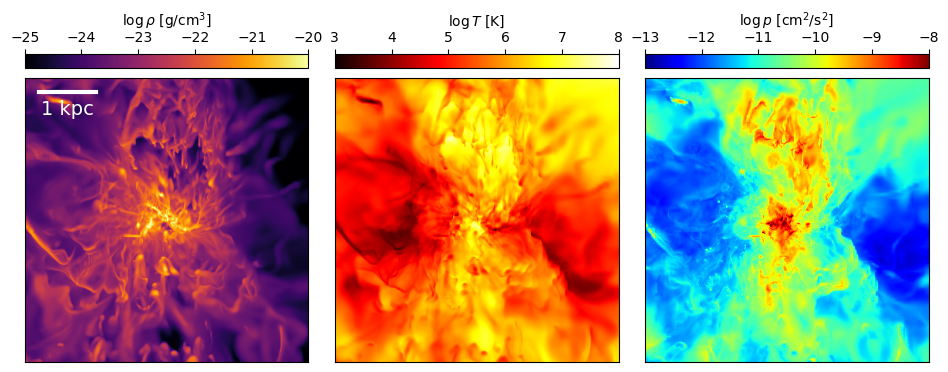

In [104]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

size_img = 5 * const.kpc

img = sim.proj_axis('density', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img, ax=axs[0], do_log=True, cmap='inferno', vmin=1e-25, vmax=1e-20, size_img=size_img)
add_cbar_to_ax(im, ax=axs[0], label=r'$\log \rho$ [${\rm g/cm^3}$]', orientation='horizontal')

img = sim.proj_axis('temp', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img, ax=axs[1], do_log=True, cmap='hot', vmin=1e3, vmax=1e8, size_img=size_img)
add_cbar_to_ax(im, ax=axs[1], label=r'$\log T$ [${\rm K}$]', orientation='horizontal')

# img = sim.proj_axis('entropy', idx_axis=X, weight='density', size_img=size_img)
# im = sim.plot_img(img, ax=axs[2], do_log=True, cmap='jet', vmin=1e28, vmax=1e32, size_img=size_img)
# add_cbar_to_ax(im, ax=axs[2], label=r'$\log \kappa$', orientation='horizontal')

img = sim.proj_axis('pressure', idx_axis=X, weight='density', size_img=size_img)
im = sim.plot_img(img, ax=axs[2], do_log=True, cmap='jet', vmin=1e-13, vmax=1e-8, size_img=size_img)
add_cbar_to_ax(im, ax=axs[2], label=r'$\log p$ [${\rm cm^2/s^2}$]', orientation='horizontal')

# img = sim.proj_axis('metallicity', idx_axis=X, weight='density', size_img=size_img)
# im = sim.plot_img(img / const.Z_sol, ax=axs[2], do_log=True, cmap='jet', vmin=1e-1, vmax=1e0, size_img=size_img)
# add_cbar_to_ax(im, ax=axs[2], label=r'$\log Z$ [$Z_\odot$]', orientation='horizontal')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
sim.add_dis_to_ax(axs[0], 1*const.kpc, size_img=size_img)


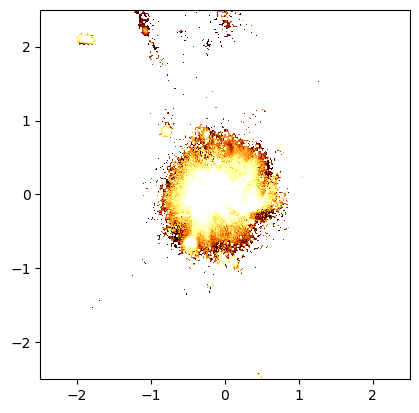

In [124]:
img = sim.proj_axis('density_star', idx_axis=X, weight='density')
im = sim.plot_img(img, do_log=True, cmap='afmhot', vmin=1e-26, vmax=1e-22)
axs[i].set_xticks([])
axs[i].set_yticks([])
    
sim.add_dis_to_ax(ax, 1*const.kpc)
add_cbar_to_ax(im, ax=ax, label=r'$\log \rho$ [${\rm g/cm^3}$]')


### PDF

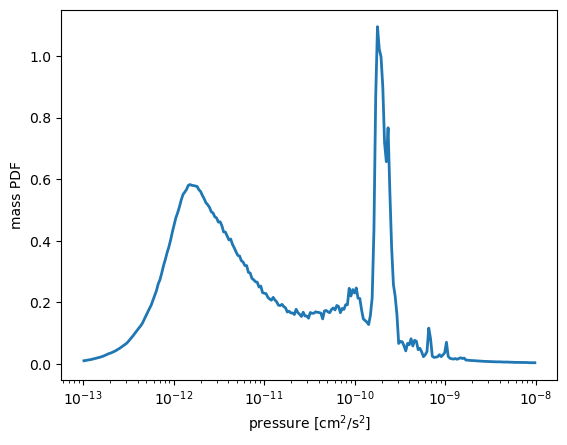

In [74]:
r = norm(sim.coord)
cond = r < 10 * const.kpc

pressure1d, pdf = calc_hist(sim.pressure[cond], vmin=1e-13, vmax=1e-8, weight=sim.density[cond], nbins=256, do_log=True, do_norm=True)
plt.xscale('log')
plt.xlabel(r'pressure [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')

plt.plot(pressure1d, pdf, lw=2)


### phasespace

Text(0.5, 0, 'mass PDF')

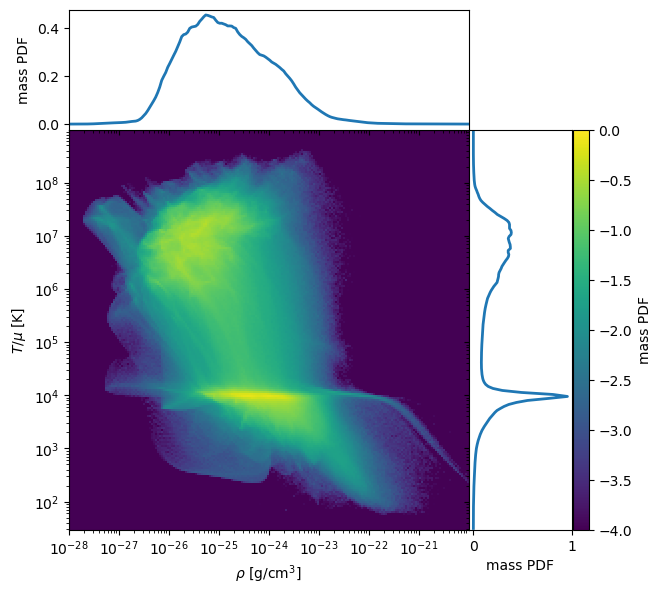

In [117]:
axs, density2d, temp2d, pdf, im = plot_pdf2d(sim.density, sim.temp, 1e-28, 1e-20, 3e1, 1e9, 1e-4, 1e0, weight=None, nbins=200)
add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='mass PDF')

axs[0].set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
axs[0].set_ylabel(r'$T/\mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')


Text(0.5, 0, 'mass PDF')

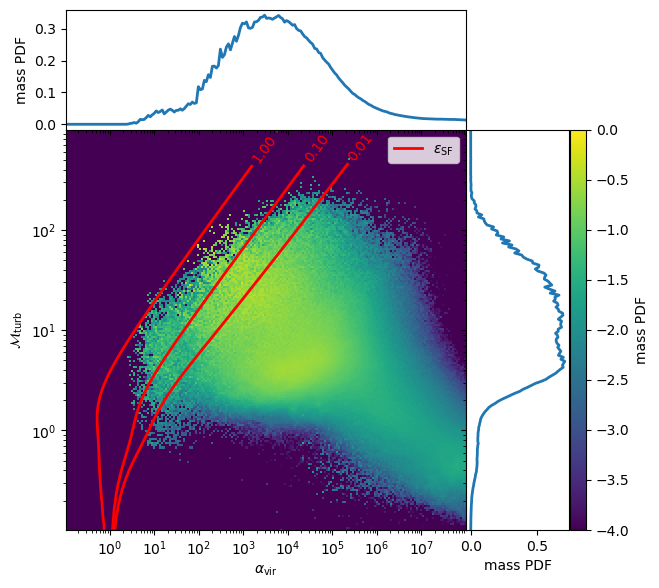

In [43]:
axs, alpha_vir2d, mach_turb2d, pdf, im = plot_pdf2d(sim.alpha_vir, sim.mach_turb, 1e-1, 1e8, 1e-1, 1e3, 1e-4, 1e0, weight=sim.density, nbins=200)
add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='mass PDF')

alpha_vir2d, mach_turb2d = np.meshgrid(alpha_vir2d, mach_turb2d, indexing='ij')
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=1.0)
cs = axs[0].contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])
add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=axs[0])

axs[0].set_xlabel(r'$\alpha_{\rm vir}$')
axs[0].set_ylabel(r'$\mathcal{M}_{\rm turb}$')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')


### angular momentum

In [76]:
r_sph_init = 1 * const.kpc
frac_shrink = 0.99
num_iter = 10

r_sph_list = np.zeros((num_iter + 1)) 
r_sph_list[0] = r_sph_init
coord_center_list = np.zeros((num_iter + 1, 3))

for i in range(num_iter):
    coord_rel_center = sim.coord - coord_center_list[i, :, None, None, None]
    r_rel_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    cond_sph = r_rel_center < r_sph_list[i]
    coord_center_list[i + 1] = np.sum(cond_sph * sim.coord * sim.density, axis=(1,2,3)) / np.sum(cond_sph * sim.density)
    r_sph_list[i + 1] = r_sph_list[i] * frac_shrink
    print(i, end="")

coord_center = coord_center_list[-1]
coord_rel_center = sim.coord - coord_center[:, None, None, None]
r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    

0123456789

(-300.0, 300.0)

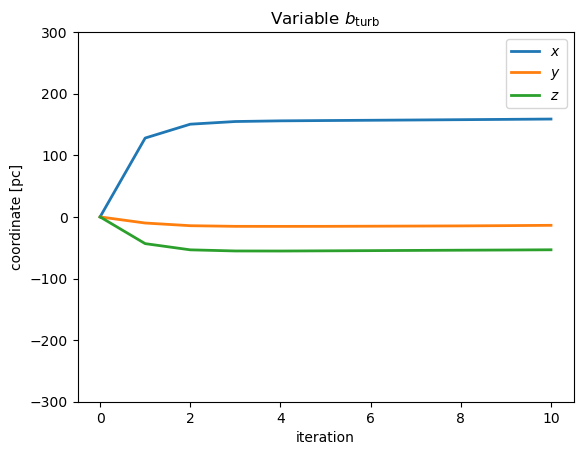

In [77]:
# plt.plot(radius_sphere_list / const.pc, color='grey', lw=2, label=r'$r_{\rm sph}$')
plt.plot(coord_center_list[:, X] / const.pc, label=r'$x$', lw=2, color='C0')
plt.plot(coord_center_list[:, Y] / const.pc, label=r'$y$', lw=2, color='C1')
plt.plot(coord_center_list[:, Z] / const.pc, label=r'$z$', lw=2, color='C2')

plt.legend()
plt.xlabel('iteration')
plt.ylabel(r'coordinate [pc]')
plt.title(sim.sim_latex)

plt.ylim(-300, 300)


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

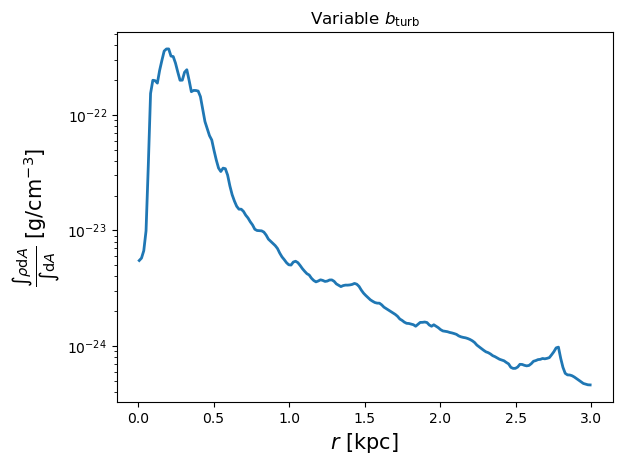

In [90]:
r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=3*const.kpc, do_log=False, nbins=200)
plt.plot(r_1d / const.kpc, rho_1d, lw=2)

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r'$\frac{\int \rho {\rm d}A}{\int {\rm d}A}$ [${\rm g/cm^{-3}}$]', fontsize=15)
plt.yscale('log')
plt.title(sim.sim_latex)


In [93]:
r_1d, vx_1d = calc_profile1d(r_center, sim.vel_vec[X], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, vy_1d = calc_profile1d(r_center, sim.vel_vec[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, vz_1d = calc_profile1d(r_center, sim.vel_vec[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)


(-300.0, 300.0)

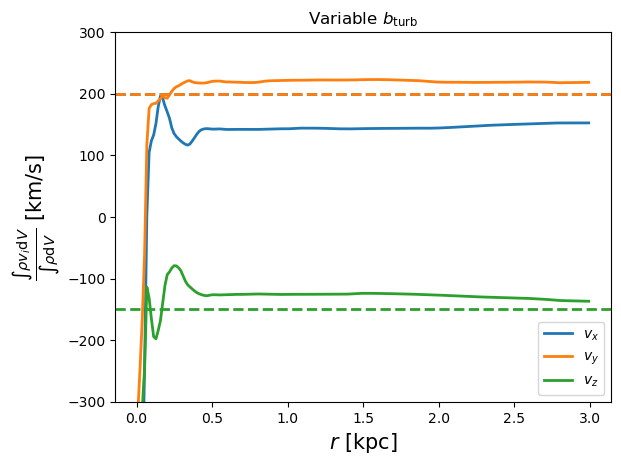

In [94]:
plt.plot(r_1d / const.kpc, vx_1d / const.km, lw=2, label=r'$v_x$', color='C0')
plt.plot(r_1d / const.kpc, vy_1d / const.km, lw=2, label=r'$v_y$', color='C1')
plt.plot(r_1d / const.kpc, vz_1d / const.km, lw=2, label=r'$v_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\frac{\int \rho v_i {\rm d}V}{\int \rho {\rm d}V}$ [${\rm km/s}$]", fontsize=15)
plt.legend()
plt.title(sim.sim_latex)

vx_bulk = 200 * const.km
vy_bulk = 200 * const.km
vz_bulk = -150 * const.km

plt.axhline(y=vx_bulk / const.km, lw=2, linestyle='--', color='C0')
plt.axhline(y=vy_bulk / const.km, lw=2, linestyle='--', color='C1')
plt.axhline(y=vz_bulk / const.km, lw=2, linestyle='--', color='C2')

plt.ylim(-300, 300)

# save_fig('bturb0p3-vbulk')


In [96]:
vel_rel_bulk = sim.vel_vec - np.array([vx_bulk, vy_bulk, vz_bulk])[:, None, None, None]
l_mom = np.cross(coord_rel_center, vel_rel_bulk, axisa=0, axisb=0, axisc=0)

r_1d, lx_1d = calc_profile1d(r_center, l_mom[X], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, ly_1d = calc_profile1d(r_center, l_mom[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)
r_1d, lz_1d = calc_profile1d(r_center, l_mom[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbins=200, weight=sim.density, do_cum=True)

jx_1d = lx_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jy_1d = ly_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jz_1d = lz_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)


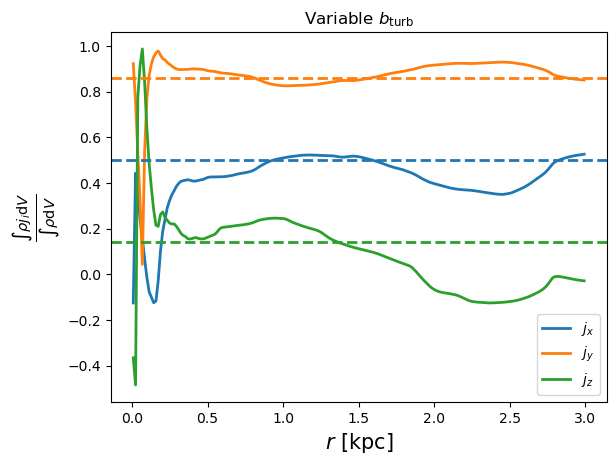

In [97]:
plt.plot(r_1d / const.kpc, jx_1d, lw=2, label=r'$j_x$', color='C0')
plt.plot(r_1d / const.kpc, jy_1d, lw=2, label=r'$j_y$', color='C1')
plt.plot(r_1d / const.kpc, jz_1d, lw=2, label=r'$j_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\frac{\int \rho j_i {\rm d}V}{\int \rho {\rm d}V}$", fontsize=15)
plt.legend()
plt.title(sim.sim_latex)

j_disk = np.array([0.5, 0.86, 0.14])
#j_disk = j_disk / norm(j_disk)

plt.axhline(y=j_disk[X], lw=2, linestyle='--', color='C0')
plt.axhline(y=j_disk[Y], lw=2, linestyle='--', color='C1')
plt.axhline(y=j_disk[Z], lw=2, linestyle='--', color='C2')

# save_fig('bturb0p3-angmom')


[]

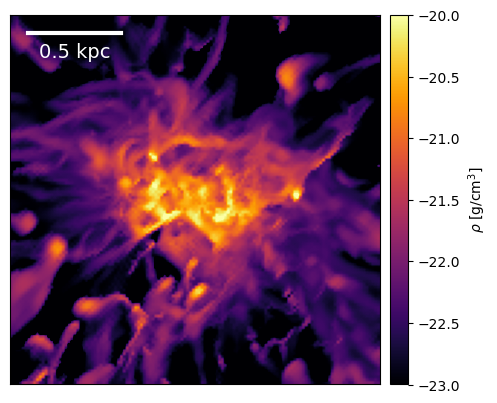

In [101]:
coord_center = np.array([0.51035193, 0.51258252, 0.49281404]) * sim.length_unit - sim.left_edge
j_disk = np.array([0.428354, 0.87663144, 0.21915786])

size_img = 2 * const.kpc
size_sample = 2 * const.kpc
num_pxl = 128
num_sample = 10000
vec_camera = np.cross(j_disk, np.array([1, 0, 0]))
#vec_camera = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, img = sim.proj_anyaxis('density', coord_center=coord_center, size_img=size_img, size_sample=size_sample, vec_camera=vec_camera, num_pxl=num_pxl, vec_north=vec_north, weight='density')

ax = plt.gca()
im = sim.plot_img(img, size_img=size_img, vmin=1e-23, vmax=1e-20, cmap='inferno', do_log=True)
add_cbar_to_ax(im, ax=ax, label=r'$\rho$ [${\rm g/cm^3}$]')

sim.add_dis_to_ax(ax, 0.5*const.kpc, size_img=size_img)
ax.set_xticks([])
ax.set_yticks([])


[]

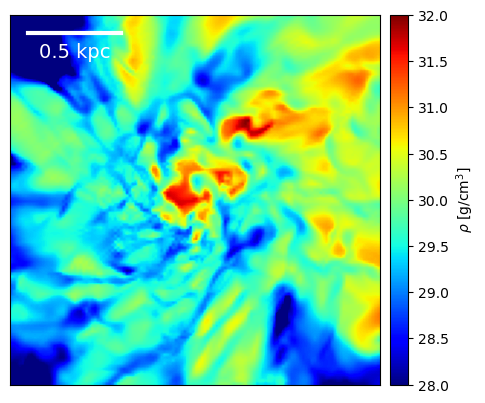

In [111]:
coord_center = np.array([0.51035193, 0.51258252, 0.49281404]) * sim.length_unit - sim.left_edge
j_disk = np.array([0.428354, 0.87663144, 0.21915786])

size_img = 2 * const.kpc
size_sample = 2 * const.kpc
num_pxl = 128
num_sample = 10000
#vec_camera = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, img = sim.proj_anyaxis('entropy', coord_center=coord_center, size_img=size_img, size_sample=size_sample, vec_camera=vec_camera, num_pxl=num_pxl, vec_north=vec_north, weight='density')

ax = plt.gca()
im = sim.plot_img(img, size_img=size_img, vmin=1e28, vmax=1e32, cmap='jet', do_log=True)
add_cbar_to_ax(im, ax=ax, label=r'$\rho$ [${\rm g/cm^3}$]')

sim.add_dis_to_ax(ax, 0.5*const.kpc, size_img=size_img)
ax.set_xticks([])
ax.set_yticks([])
